This notebook trains and evaluates a multi-class classifier (8 diagnoses) on BCN20000 using a ResNet18 head. It mirrors the binary pipeline so results are comparable:
- Metrics: Accuracy, macro Recall, macro AUROC (OVR), per-class confusion
- Validation uses TTA (flip averaging)
- Artifacts: checkpoint, metrics JSON, multi-run log, history CSV, predictions CSV, plots (loss/acc, confusion matrices, ROC-OVR)
All reusable logic is imported from src/utils.

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

from src.utils.device_utils import get_device
from src.utils.models_utils import build_resnet18_multiclass
from src.utils.data_utils import make_train_val_loaders_multiclass
from src.utils.inference_utils import collect_outputs_mc
from src.utils.metrics_utils import compute_metrics_multiclass
from src.utils.plot_utils import (
    plot_confusion_mc, plot_roc_multi, plot_loss_acc_from_history
)

import torch
from torch import nn
import matplotlib.pyplot as plt
import csv, json, datetime

The following helpers build and train a multi-class ResNet18, and evaluate on the validation set. Training runs for 15 epochs to match the binary notebook.

In [2]:
def evaluate_basic_mc(model, data_loader, device, criterion):
    model.eval()
    total, correct, running = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return running / max(1, len(data_loader)), correct / max(1, total)

def train_model_mc(model, train_loader, val_loader, device, epochs=15, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"loss": [], "val_loss": [], "val_acc": []}
    from tqdm.auto import tqdm
    for epoch in range(1, epochs + 1):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=True)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()
            pbar.set_postfix(batch_loss=f"{loss.item():.4f}")
        tr_loss = running / max(1, len(train_loader))
        vl_loss, vl_acc = evaluate_basic_mc(model, val_loader, device, criterion)
        history["loss"].append(tr_loss)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(vl_acc)
    return model, history

To mirror the binary results view, we show metrics inline and also save all artifacts.

In [3]:
def display_metrics_inline_mc(metrics):
    fig = plt.figure(figsize=(6,4))
    names = ["accuracy", "recall_macro", "auroc_macro_ovr"]
    vals = [metrics.get("accuracy", 0.0), metrics.get("recall_macro", 0.0), metrics.get("auroc_macro_ovr", 0.0)]
    plt.bar(names, vals)
    plt.ylim(0, 1)
    for i, v in enumerate(vals):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
    plt.title("Validation Metrics (Multi-class)")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.show()

Artifact writers and logging: checkpoint, metrics JSON, multi-run CSV, history CSV, predictions CSV. Loss/accuracy plots are generated from the saved history CSV for consistency with the binary results notebook.

In [4]:
def save_checkpoint_mc(model, path="../artifacts/checkpoints/multiclass_resnet18.pt"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({"state_dict": model.state_dict()}, path)
    return path

def save_metrics_json_mc(metrics, label_names, path="../artifacts/multiclass_metrics.json"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    data = {"label_names": label_names}
    data.update(metrics)
    with open(path, "w") as f:
        json.dump(data, f, indent=2)
    return path

def append_metrics_log_mc(metrics, log_path="../artifacts/metrics_log_multiclass.csv", run_name="multiclass_resnet18"):
    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    file_exists = os.path.isfile(log_path)
    with open(log_path, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["timestamp", "run_name", "accuracy", "recall_macro", "auroc_macro_ovr", "epochs", "batch_size", "lr"])
        writer.writerow([
            datetime.datetime.now().isoformat(timespec="seconds"),
            run_name,
            metrics.get("accuracy", ""),
            metrics.get("recall_macro", ""),
            metrics.get("auroc_macro_ovr", ""),
            metrics.get("epochs", ""),
            metrics.get("batch_size", ""),
            metrics.get("lr", "")
        ])
    return log_path

def save_history_csv_mc(history, path="../artifacts/history_multiclass_resnet18.csv"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_acc"])
        for i, (tr, vl, va) in enumerate(zip(history["loss"], history["val_loss"], history["val_acc"]), start=1):
            writer.writerow([i, tr, vl, va])
    return path

def save_predictions_csv_mc(y_true, y_pred, y_prob, label_names, path="../artifacts/val_predictions_multiclass.csv"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", newline="") as f:
        writer = csv.writer(f)
        header = ["y_true", "y_pred"] + [f"p_{n}" for n in label_names]
        writer.writerow(header)
        for t, p, prob_row in zip(y_true, y_pred, y_prob):
            row = [label_names[t], label_names[p]] + [float(v) for v in prob_row.tolist()]
            writer.writerow(row)
    return path

End-to-end orchestration: build loaders, train, evaluate with TTA via utils, save artifacts, draw plots, and display inline metrics. Epochs, batch size, and LR match the binary notebook (15, 64, 1e-3).

In [5]:
def run_all_multiclass(epochs=15, batch_size=64, lr=1e-3, run_name="multiclass_resnet18_tta15e"):
    device = get_device()
    train_loader, val_loader, label_names = make_train_val_loaders_multiclass(batch_size=batch_size)
    model = build_resnet18_multiclass(num_classes=len(label_names), use_pretrained=True).to(device)
    model, history = train_model_mc(model, train_loader, val_loader, device, epochs=epochs, lr=lr)
    y_true, y_pred, y_prob = collect_outputs_mc(model, val_loader, device, use_tta=True)
    metrics = compute_metrics_multiclass(y_true, y_pred, y_prob, average="macro")
    metrics["epochs"] = epochs
    metrics["batch_size"] = batch_size
    metrics["lr"] = lr
    display_metrics_inline_mc(metrics)
    ckpt = save_checkpoint_mc(model, "../artifacts/checkpoints/multiclass_resnet18.pt")
    mjson = save_metrics_json_mc(metrics, label_names, "../artifacts/multiclass_metrics.json")
    mlog = append_metrics_log_mc(metrics, "../artifacts/metrics_log_multiclass.csv", run_name=run_name)
    hcsv = save_history_csv_mc(history, "../artifacts/history_multiclass_resnet18.csv")
    pcsv = save_predictions_csv_mc(y_true, y_pred, y_prob, label_names, "../artifacts/val_predictions_multiclass.csv")
    plots_dir = "../artifacts/plots"
    plot_loss_acc_from_history("../artifacts/history_multiclass_resnet18.csv", show=True, out_prefix=os.path.join(plots_dir, run_name))
    plot_confusion_mc(y_true, y_pred, label_names, normalize=False, show=True, save_path=os.path.join(plots_dir, f"{run_name}_confusion.png"))
    plot_confusion_mc(y_true, y_pred, label_names, normalize=True, show=True, save_path=os.path.join(plots_dir, f"{run_name}_confusion_norm.png"))
    plot_roc_multi(y_true, y_prob, label_names, show=True, save_path=os.path.join(plots_dir, f"{run_name}_roc_ovr.png"))
    return {"metrics": metrics, "checkpoint": ckpt, "metrics_json": mjson, "metrics_log": mlog, "history_csv": hcsv, "predictions_csv": pcsv, "label_names": label_names}

Run

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Epoch 1/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/194 [00:00<?, ?it/s]

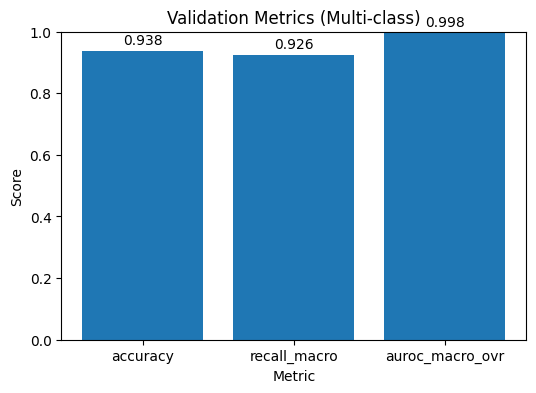

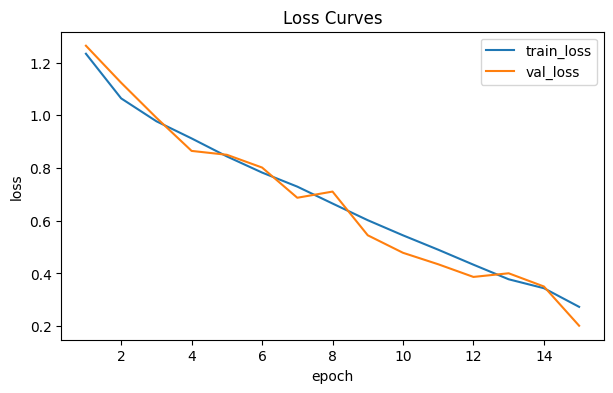

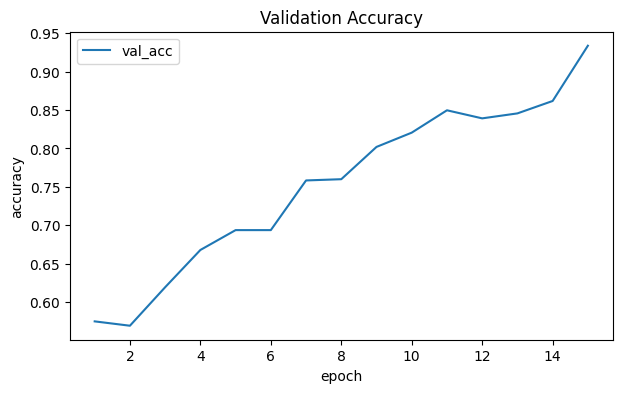

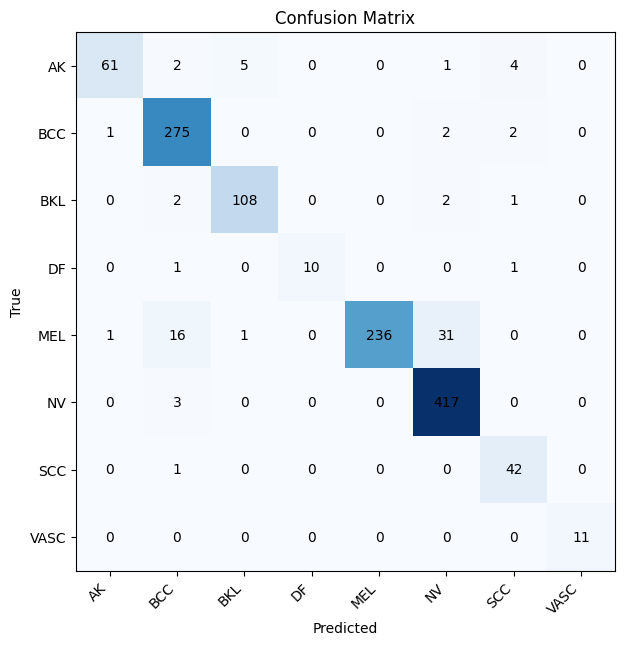

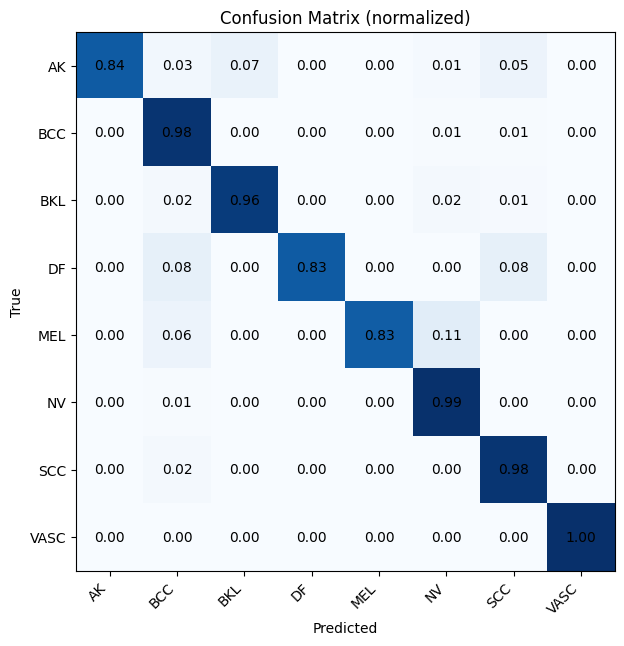

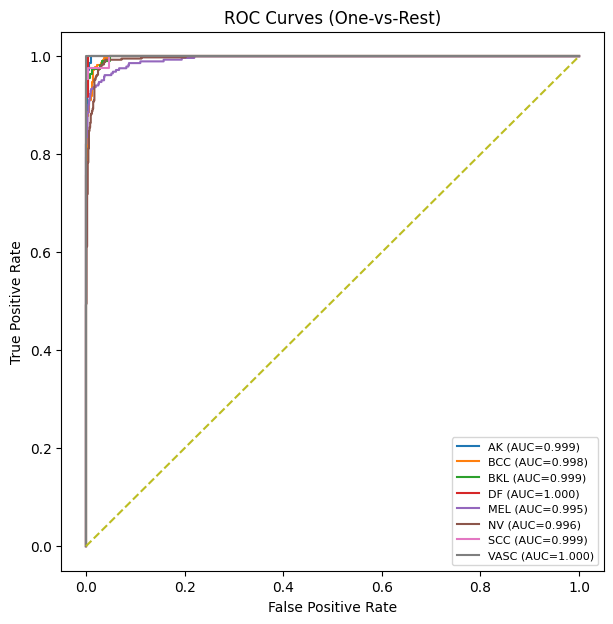

{'metrics': {'accuracy': 0.9377526273241714,
  'recall_macro': 0.9255645431954983,
  'auroc_macro_ovr': 0.9980264074028743,
  'epochs': 15,
  'batch_size': 64,
  'lr': 0.001},
 'checkpoint': '../artifacts/checkpoints/multiclass_resnet18.pt',
 'metrics_json': '../artifacts/multiclass_metrics.json',
 'metrics_log': '../artifacts/metrics_log_multiclass.csv',
 'history_csv': '../artifacts/history_multiclass_resnet18.csv',
 'predictions_csv': '../artifacts/val_predictions_multiclass.csv',
 'label_names': ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']}

In [6]:
def run_now():
    return run_all_multiclass(epochs=15, batch_size=64, lr=1e-3, run_name="multiclass_resnet18_tta15e")

results = run_now()
results